<a href="https://colab.research.google.com/github/vahadruya/Capstone-Project-Unsupervised-ML-Topic-Modelling/blob/main/Intermediate_Colab_Notebooks/Unsupervised_ML_Capstone_Day2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Day 2 - A Complete modeling of the data using LDA. Additional Pre-processing steps included:
*   Expanding Contractions
*   Removing Digits and Whitespaces
*   Lemmatization instead of Stemming

A more refined evaluation of the model using metrics such as Accuracy and Precision. Also included Wordmaps to visualise top words for each topic

**NOTE: pyLDAvis is recently incompatible with the updated attribute of sklearn get_feature_names_out() instead of get_feature_names. I have updated this in the sklearn.py file of pyLDAvis.sklearn.prepare locally to deal with the issue. Exception handling is utilised in case the AttributeError persists**

In [ ]:
import pandas as pd
import numpy as np
import glob
import re
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from wordcloud import WordCloud
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pd.set_option('display.max_colwidth', None)

## 1. Reading the Data

In [ ]:
# Function for organising one article into 'Title' and 'Description' Columns
def organise_data(df):
  df['Description'] = ''
  for row in df[df.columns.values[0]]:
    df['Description'] += ' ' + row
  df['Title'] = df.columns.values[0]
  df = pd.DataFrame(df[['Title', 'Description']].loc[0]).transpose()
  return df

# Function for reading files from one particular category
def read_from_folder(category, path):
  files = glob.glob(path + category + "/*.txt")
  df = pd.DataFrame(pd.read_table(files[0]))
  df = organise_data(df)
  
  # Reading the rest of the files in the category, assigning a column for the given category name, and concatenating to the above DataFrame
  for i in range(1, len(files)):
    try:
      next_df = pd.DataFrame(pd.read_table(files[i]))
    except UnicodeDecodeError:
      next_df = pd.DataFrame(pd.read_table(files[i], encoding = 'ISO-8859-1'))
    except pd.errors.ParserError:
      next_df = pd.DataFrame(pd.read_table(files[i], quoting=csv.QUOTE_NONE))
    next_df = organise_data(next_df)
    df = pd.concat([df, next_df], axis=0)
    df['Category'] = category.capitalize()
    df = df.reset_index(drop=True)
  return df

# Function for reading files from all categories and concatenating into one single DataFrame
def read_from_folders(categories, path):
  category_dict = dict()
  for category in categories:
    category_dict[category] = read_from_folder(category, path)
  final_data = pd.concat([category_dict[category] for category in categories], axis=0).reset_index(drop=True)
  return final_data

In [ ]:
path = '/content/drive/MyDrive/ALMA BETTER/Module 4/#CAPSTONE 3 - UNSUPERVISED/Data/'
folders = ['business', 'entertainment', 'politics', 'sport', 'tech']

In [ ]:
data = read_from_folders(folders, path)

In [ ]:
data.shape

(2225, 3)

In [ ]:
data.drop_duplicates(inplace=True, ignore_index = True)

In [ ]:
data.shape

(2125, 3)

In [ ]:
data['Category'].value_counts()

Business         503
Sport            503
Politics         403
Entertainment    369
Tech             347
Name: Category, dtype: int64

<AxesSubplot:>

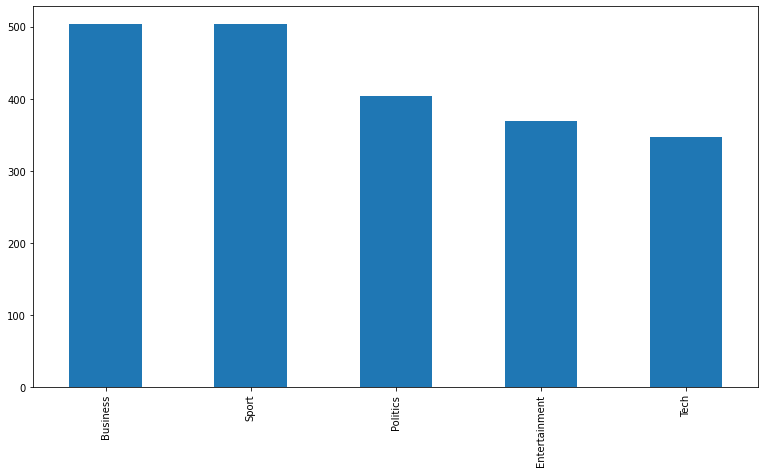

In [ ]:
data['Category'].value_counts().plot(kind='bar', figsize = (13,7))

## 2. Data Pre-Processing

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### 2.1 Expanding Contractions

In [ ]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import contractions

In [ ]:
# Function for expanding contracted words
def expand_contractions(text):
  expanded_words = []
  for word in text.split():
    expanded_words.append(contractions.fix(word))
  return ' '.join(expanded_words)

In [ ]:
data['Description'] = data['Description'].apply(expand_contractions)

### 2.2 Removing Punctuations

In [ ]:
# Removes all Punctuations
def remove_punc(text):
  return re.sub(r'\W',' ',text)

In [ ]:
data['Description'] = data['Description'].apply(remove_punc)

### 2.3 Removing Digits and White Spaces

In [ ]:
def remove_digits(text):
  return re.sub(r'\d',' ',text)

def remove_whitespace(text):
  return re.sub(r'\s+',' ',text)

In [ ]:
data['Description'] = data['Description'].apply(remove_digits)
data['Description'] = data['Description'].apply(remove_whitespace)

### 2.4 Removing Stopwords

In [ ]:
def remove_stopwords(text, stop_words):
  text = [word.lower() for word in text.split() if word.lower() not in stop_words]
  return ' '.join(text)

In [ ]:
stop_words = stopwords.words('english')

In [ ]:
data['Description'] = data['Description'].apply(remove_stopwords, stop_words = stop_words)

In [ ]:
def top_n_words_features(count_vectorizer, text, n_words):
    '''
    returns a dataframe of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized = count_vectorizer.fit_transform(text)
    tokens_df = pd.DataFrame(vectorized.todense(), columns = count_vectorizer.get_feature_names_out())
    top_df = pd.DataFrame(tokens_df.sum().sort_values(ascending=False).head(n_words)).rename(columns = {0:'Occurences'})
    return top_df, len(count_vectorizer.get_feature_names_out())

In [ ]:
vectorizer = CountVectorizer()
top_words, n_features_raw = top_n_words_features(vectorizer, data['Description'], 10)

<AxesSubplot:>

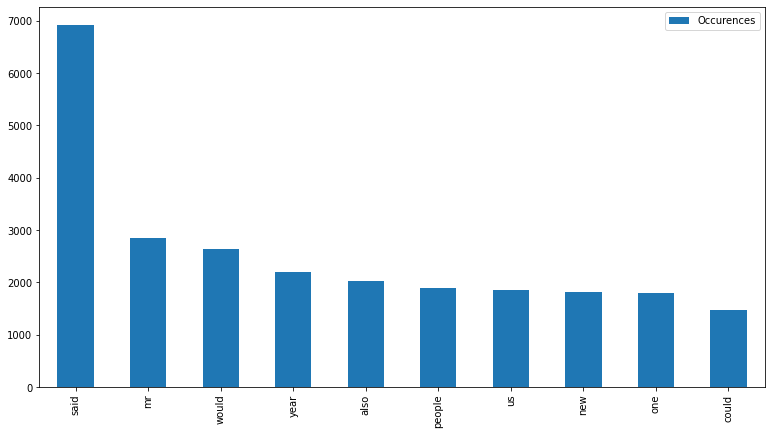

In [ ]:
top_words.plot(kind='bar', figsize = (13,7))

In [ ]:
n_features_raw

27573

### 2.5 Text Lemmatization

In [ ]:
# def stemming(text, stemmer):
#   text = [stemmer.stem(word) for word in text.split()]
#   return ' '.join(text)

In [ ]:
# sb_stemmer = SnowballStemmer('english')

In [ ]:
# data['Description'] = data['Description'].apply(stemming, stemmer=sb_stemmer)

In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
# Function for lemmatizing the verbs
def lemmatize_(text, lemmatizer):
  text = [lemmatizer.lemmatize(word, pos='v') for word in text.split()]
  return ' '.join(text)

In [ ]:
lemmatiser =  WordNetLemmatizer()
data['Description'] = data['Description'].apply(lemmatize_, lemmatizer = lemmatiser)

In [ ]:
top_words, n_features = top_n_words_features(vectorizer, data['Description'], 10)

<AxesSubplot:>

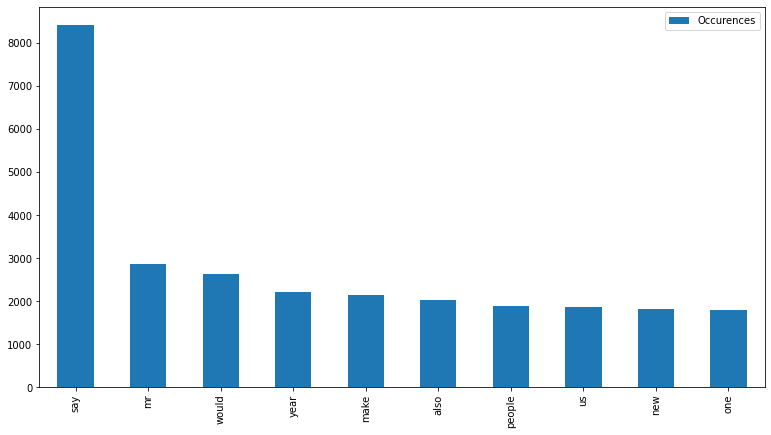

In [ ]:
top_words.plot(kind='bar', figsize = (13,7))

In [ ]:
n_features

22545

### 2.6 Removing further stopwords and Tokenising

In [ ]:
stop_words.extend(['say', 'mr', 'would', 'also'])
data['Description'] = data['Description'].apply(remove_stopwords, stop_words = stop_words)

In [ ]:
tokeniser = CountVectorizer(max_df = 0.95, min_df = 0.02)
tokenised_data = tokeniser.fit_transform(data['Description'])

In [ ]:
top_words, n_features = top_n_words_features(tokeniser, data['Description'], 10)

<AxesSubplot:>

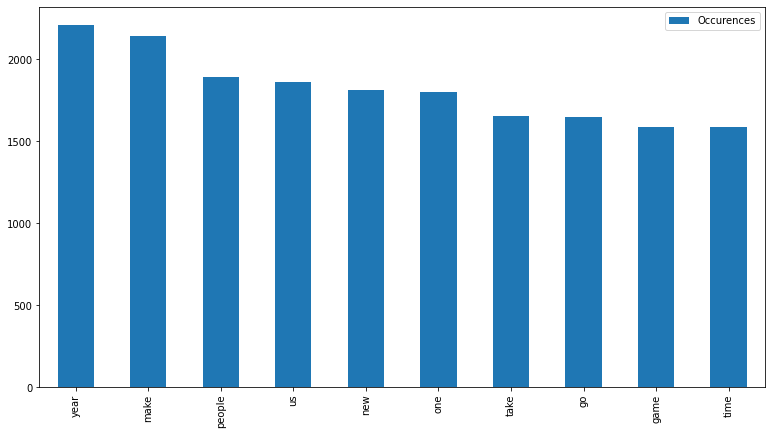

In [ ]:
top_words.plot(kind = 'bar', figsize = (13,7))

In [ ]:
print(f'Number of features after vectorization = {n_features}')
print(f'\nAfter Text Pre-processing, {round((n_features_raw - n_features)*100/n_features_raw, 2)}% of contextually insignificant features have been removed')

Number of features after vectorization = 1436

After Text Pre-processing, 94.79% of contextually insignificant features have been removed


## 3. LDA

### 3.1 LDA Model Fitting with Hyperparameter tuning

In [ ]:
%%time
lda = LatentDirichletAllocation(random_state = 42)
grid_params = {'n_components' : list(range(5,6))}
lda_model = GridSearchCV(lda, param_grid = grid_params)
lda_model.fit(tokenised_data)

CPU times: user 1min 2s, sys: 362 ms, total: 1min 3s
Wall time: 1min 14s


GridSearchCV(estimator=LatentDirichletAllocation(random_state=42),
             param_grid={'n_components': [5]})

In [ ]:
best_lda_model = lda_model.best_estimator_
print("Parameters on Best LDA Model" , lda_model.best_params_)
print("Best log likelihood Score for the LDA model",lda_model.best_score_)
print("LDA model Perplexity on data", best_lda_model.perplexity(tokenised_data))

Parameters on Best LDA Model {'n_components': 5}
Best log likelihood Score for the LDA model -439502.19440800435
LDA model Perplexity on data 740.7448153913665


### 3.2 Visualisation of topics

In [ ]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [ ]:
try:
  lda_panel = pyLDAvis.sklearn.prepare(best_lda_model, tokenised_data, tokeniser, mds='tsne')
  lda_panel
except AttributeError:
  pass

### 3.3 Assigning the Topic names to each document

In [ ]:
def assign_topics(data, tokenised, model):  
  # Array of probabilites for each topic for each document. Shape - (n_documents, n_topics)
  topic_dist = model.transform(tokenised)
  
  topics = []
  # Assigns (index+1) of the topic with maximum probability as the topic name for the particular document
  for doc in topic_dist:
    topics.append(np.argmax(np.abs(doc))+1)
  
  # Convert to a Dataframe and merge with the original pre-processed dataframe with documents as an additional column
  topics_df = pd.DataFrame(topics).rename(columns = {0:'Topic_LDA'})
  return pd.merge(data, topics_df, left_index = True, right_index = True)

In [ ]:
result_df = assign_topics(data, tokenised_data, best_lda_model)

### 3.4 Comparison of Topics obtained through LDA with input Categories

In [ ]:
result_df.groupby(['Category', 'Topic_LDA'])['Title'].count()

Category       Topic_LDA
Business       2            430
               3             13
               4             59
               5              1
Entertainment  1            337
               2              4
               3              8
               4             18
               5              2
Politics       1              1
               3              2
               4            399
               5              1
Sport          1              2
               2              3
               4              5
               5            493
Tech           1             10
               2              4
               3            316
               4              8
               5              9
Name: Title, dtype: int64

In [ ]:
def convert_labels(result):  
  to_map = result.groupby(['Category', 'Topic_LDA'], as_index=False)['Title'].count()
  
  # Converts the groupby dataframe to a Dataframe with first column as input category and second as the label through LDA to be mapped
  to_map = to_map.groupby('Category', as_index=False).apply(lambda x: x['Topic_LDA'][x['Title'].idxmax()]).rename(columns = str).rename(columns = {'None':'LDA'})
  
  # Mapping and updating the TOpic_LDA column
  to_map_dict = dict(zip(to_map['LDA'], to_map['Category']))
  result['Topic_LDA'] = result['Topic_LDA'].map(to_map_dict)
  for category in to_map_dict:
    print(f'{category} is mapped to {to_map_dict[category]}')
  return result

In [ ]:
result_df = convert_labels(result_df)

2 is mapped to Business
1 is mapped to Entertainment
4 is mapped to Politics
5 is mapped to Sport
3 is mapped to Tech


### 3.5 Computing the Model Accuracy and individual Topic Precisions

In [ ]:
# Plotting the count of Articles categorised by each category and comparing with input Categories
def aggregate_plot(result_df):
  '''Plots the number of articles categorised in each category by the LDA
  and compared with the original categorisation provided as input'''
  aggregated_input = pd.DataFrame(result_df['Category'].value_counts())
  aggregated_LDA = pd.DataFrame(result_df['Topic_LDA'].value_counts())
  aggregated = pd.merge(aggregated_input, aggregated_LDA, left_index=True, right_index=True)
  aggregated.plot(kind='bar', figsize=(13,7))
  plt.show()

# Computing the model accuracy
def model_accuracy(result):
  '''Computes the model accuracy, defined as the number of articles
  correctly categorised to the total number of articles'''
  
  df1 = result.groupby(['Category', 'Topic_LDA'], as_index=False)['Title'].count().rename(columns = {'Title':'Count'})
  
  # Articles correctly categorised in the topic 
  correct_preds = df1[df1['Category'] == df1['Topic_LDA']]['Count'].reset_index()['Count'].sum()
  
  total_accuracy = correct_preds/result.shape[0]
  return total_accuracy * 100

# Computing the precision for each topic modeled by the LDA model
def topic_precision(result):
  ''' Gives the precision for each category. Defined by the number of articles
  correctly categorised to the total articles in the topic through LDA'''

  df1 = result.groupby(['Category', 'Topic_LDA'], as_index=False)['Title'].count().rename(columns = {'Title':'Count'})
  
  # Total articles present in each predicted topic
  predicted_articles_total = df1.groupby('Topic_LDA')['Count'].sum().reset_index()
  
  # Correct articles predicted in each topic
  predicted_articles = df1[df1['Category'] == df1['Topic_LDA']]['Count'].reset_index()['Count']
  
  # Calculating the precision
  predicted_articles_total['Count'] = (predicted_articles/predicted_articles_total['Count'])*100
  return predicted_articles_total.rename(columns = {'Count':'Precision'})

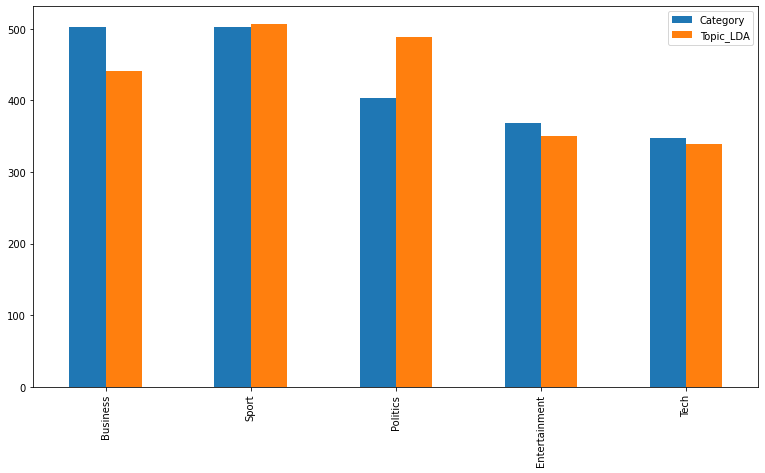

In [ ]:
aggregate_plot(result_df)

In [ ]:
print(f'The LDA model has an accuracy of {round(model_accuracy(result_df),2)}%')

The LDA model has an accuracy of 92.94%


In [ ]:
topic_precision(result_df)

,Topic_LDA,Precision
0,Business,97.505669
1,Entertainment,96.285714
2,Politics,81.595092
3,Sport,97.430830
4,Tech,93.215339


### 3.6 Top words for each topic

In [ ]:
def top_n_terms(vectorizer, model, n_top_words):
  words = vectorizer.get_feature_names_out()
  top_words_topic = []
  for topic, weights in enumerate(model.components_):
    word_weights = dict()
    indices = np.argsort(weights)[::-1][:n_top_words]
    top_words = words[indices]
    top_weights = weights[indices]
    for i in range(len(words[indices])):
      word_weights[top_words[i]] = top_weights[i]
    top_words_topic.append(word_weights)
  return top_words_topic

def plot_wordcloud(topic_term_freq):
  '''Plots a word cloud, sizing proportional to frequency of the word in the topic'''
  
  colours = ['black', 'steelblue', 'darkslateblue', 'darkolivegreen', 'khaki']
  wordcloud = WordCloud(width = 1300, height = 800,
                  background_color = random.choice(colours),
                  min_font_size = 10).generate(' '.join(list(topic_term_freq.keys())))
  wordcloud = wordcloud.generate_from_frequencies(frequencies = topic_term_freq)
  plt.figure(figsize = (13,8), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.tight_layout(pad = 0)
  plt.show()

In [ ]:
top_words = top_n_terms(tokeniser, best_lda_model, 50)

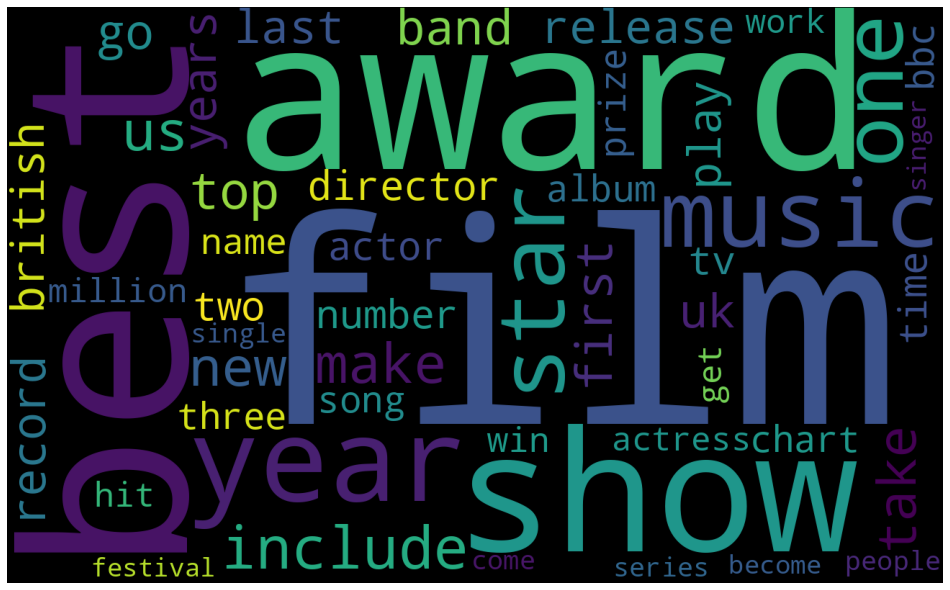

In [ ]:
plot_wordcloud(top_words[0])

*   Looking at the word distributions, it can be concluded that this is the **Entertainment** topic

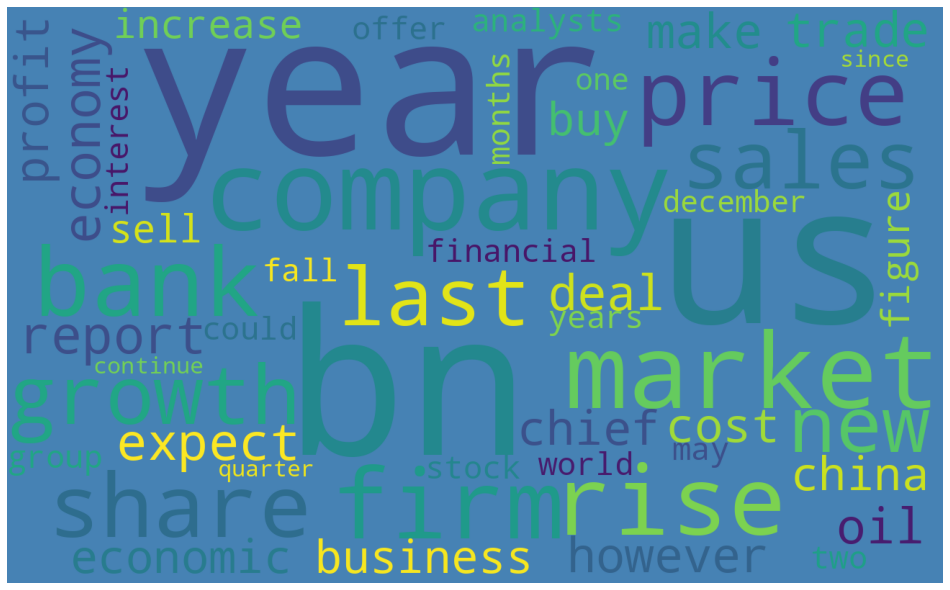

In [ ]:
plot_wordcloud(top_words[1])

*   Looking at the word distributions, it can be concluded that this is the **Business** topic

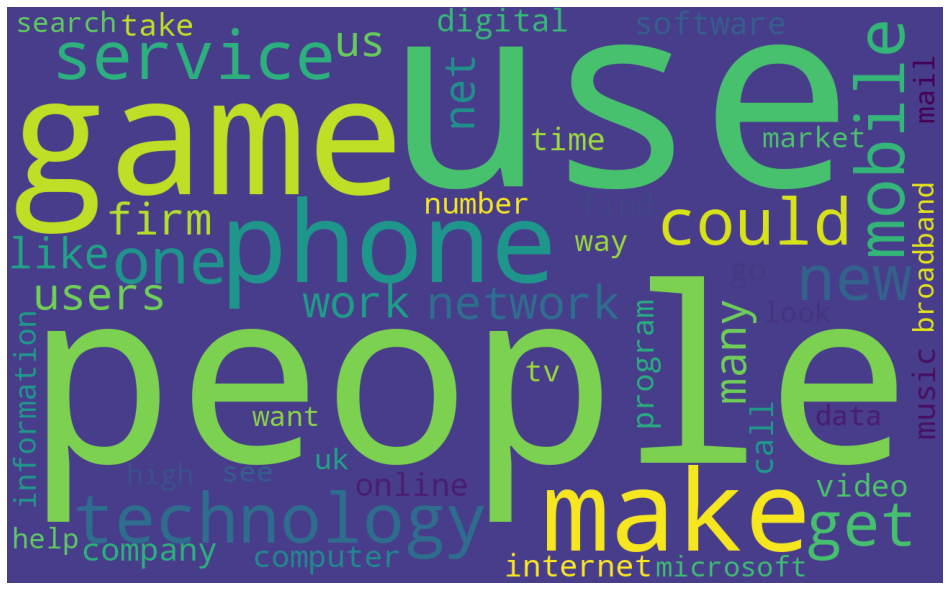

In [ ]:
plot_wordcloud(top_words[2])

*   Looking at the word distributions, it can be concluded that this is the **Tech** topic

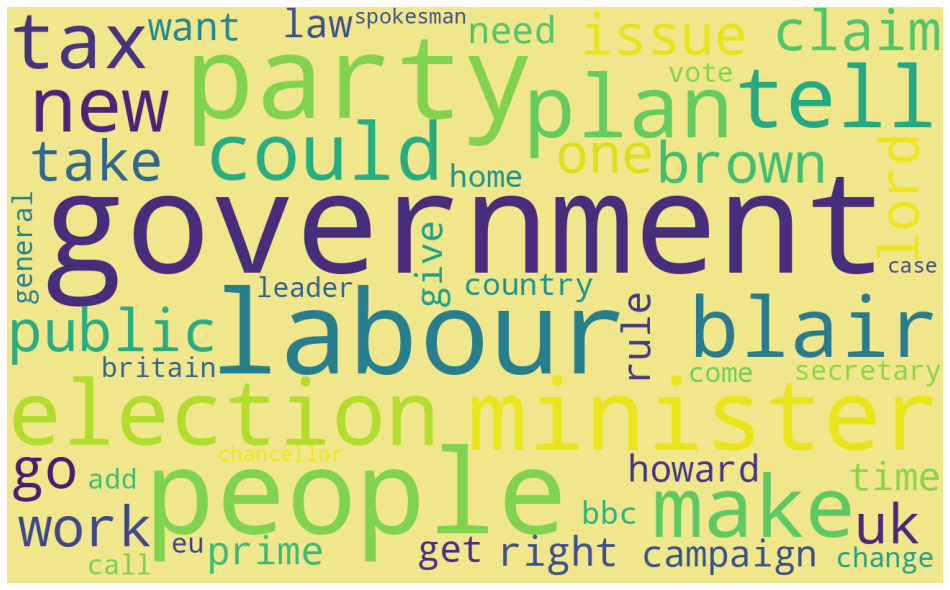

In [ ]:
plot_wordcloud(top_words[3])

*   Looking at the word distributions, it can be concluded that this is the **Politics** topic

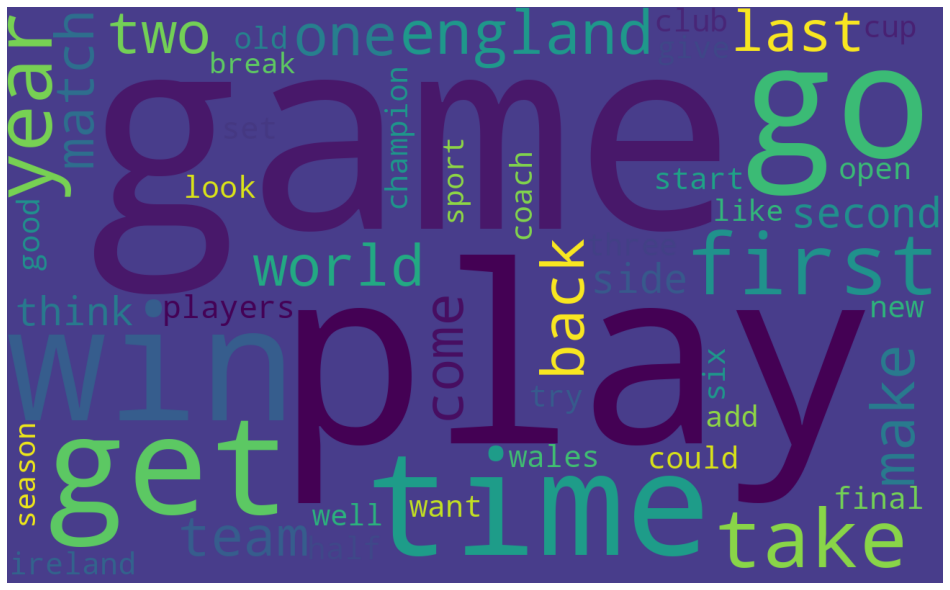

In [ ]:
plot_wordcloud(top_words[4])

*   Looking at the word distributions, it can be concluded that this is the **Sport** topic